Code for **"Flash/No Flash"** figure. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from utils.denoising_utils import *
from utils.sr_utils import load_LR_HR_imgs_sr
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True

# Load image

HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)


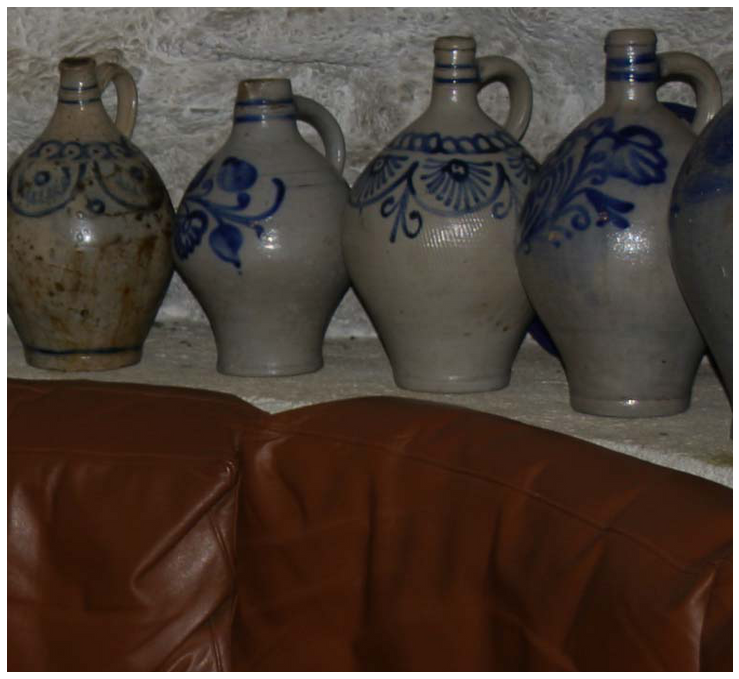

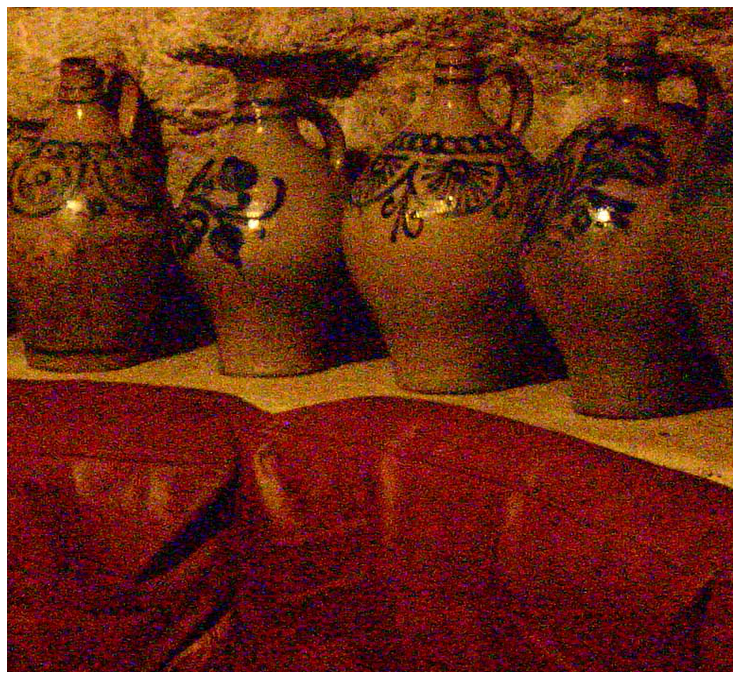

In [2]:
imgs = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')
img_flash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_flash_np = pil_to_np(img_flash)

img_noflash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_01_noflash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_noflash_np = pil_to_np(img_noflash)

# g = plot_image_grid([img_flash_np, img_noflash_np],3,12)
g = plot_image_grid([img_flash_np],3,12)
g = plot_image_grid([img_noflash_np],3,12)

# Setup

In [3]:
pad = 'reflection'
OPT_OVER = 'net'

num_iter = 1001
LR = 0.1 
OPTIMIZER = 'adam'
reg_noise_std = 0.0
show_every = 50
figsize = 6

# We will use flash image as input
input_depth = 3
net_input =np_to_torch(img_flash_np).type(dtype)

In [6]:
# nchan = 80
# net = skip(input_depth, 3, num_channels_down = [nchan]*5, 
#                         num_channels_up   = [nchan]*5,
#                         num_channels_skip = [4, 4, 4, 4, 4], 
#                         upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
#                         need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

nchan = 32
# from models.decp_skip import decp_skip
# net = skip(input_depth, 3, num_channels_down = [nchan]*5, 
#                         num_channels_up   = [nchan]*5,
#                         num_channels_skip = [4, 4, 4, 4, 4], 
#                         upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
#                         need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
# print(decp_skip)
nlayers=4 #5
net = skip(input_depth, 3, num_channels_down = [nchan]*nlayers, 
                        num_channels_up   = [nchan]*nlayers,
                        num_channels_skip = [4]*nlayers, 
                        upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
                        need_sigmoid=True, need_bias=True, pad=pad)
net.type(dtype)
mse = torch.nn.MSELoss().type(dtype)

img_flash_var = np_to_torch(img_flash_np).type(dtype)
img_noflash_var = np_to_torch(img_noflash_np).type(dtype)

# Optimize

Starting optimization with ADAM


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


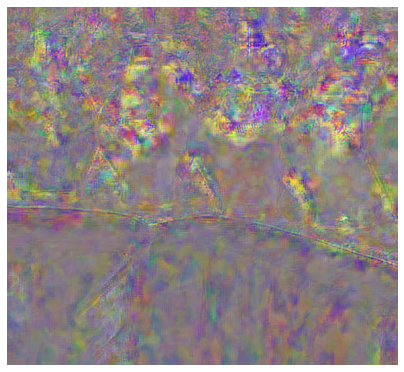

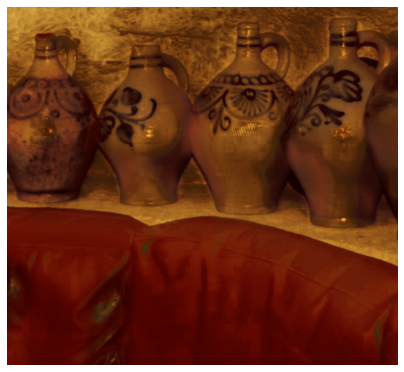

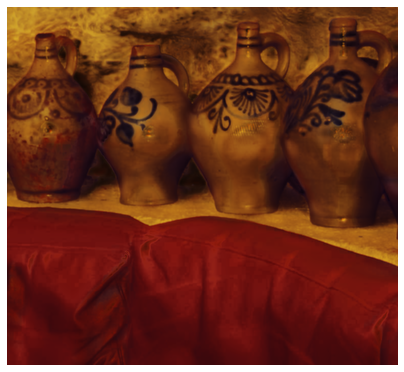

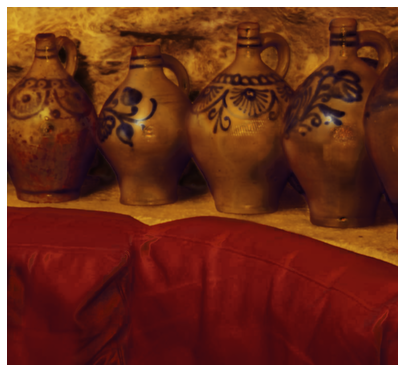

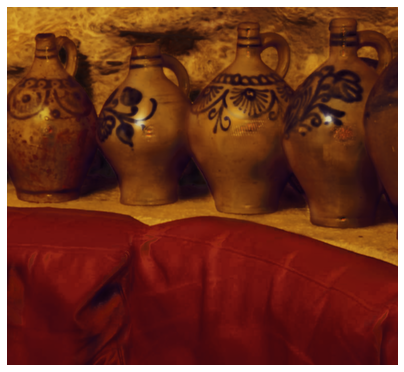

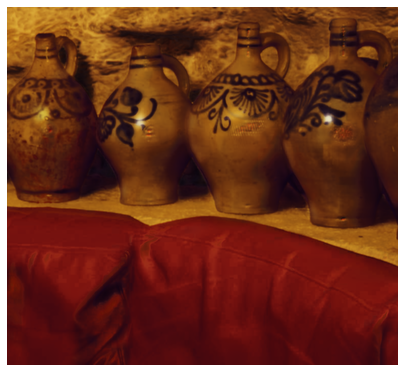

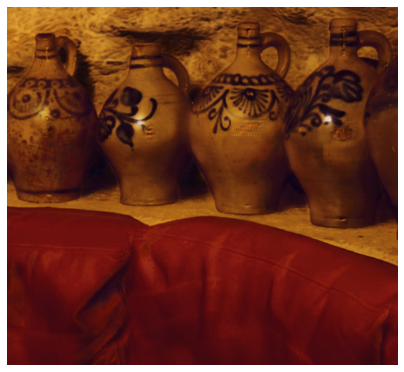

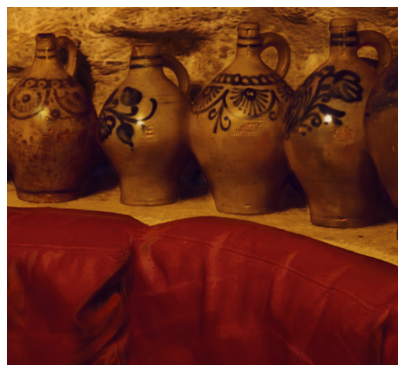

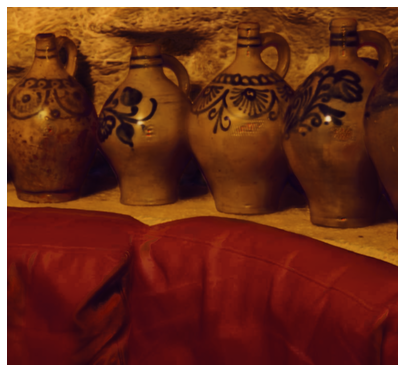

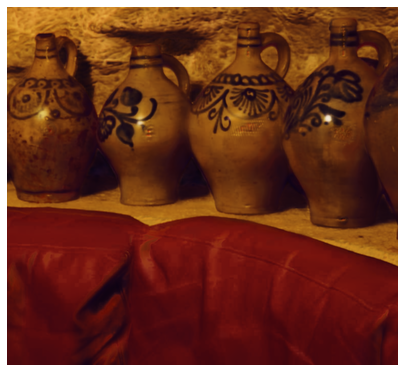

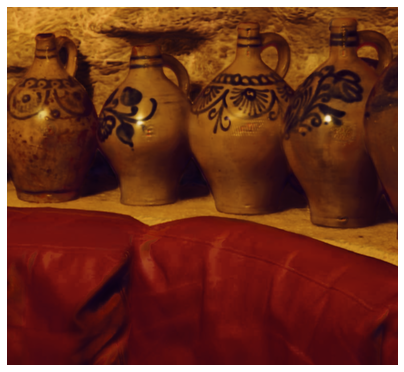

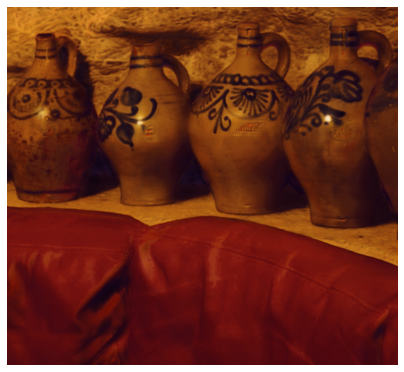

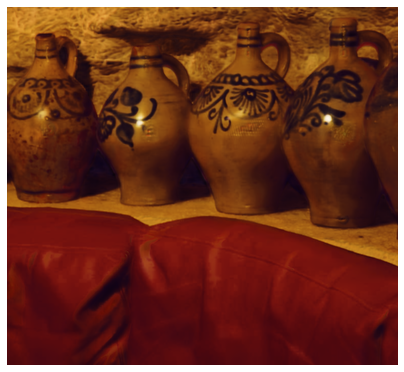

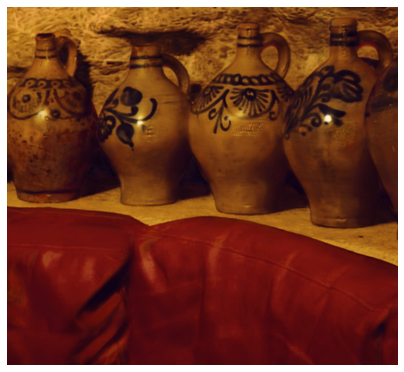

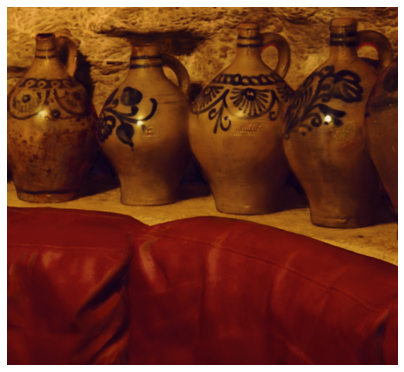

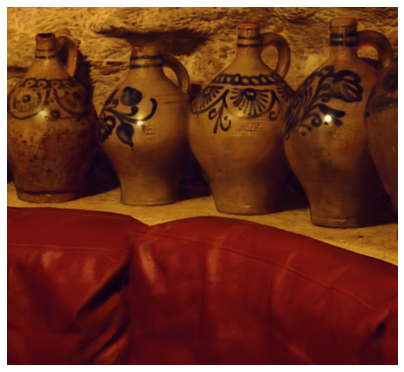

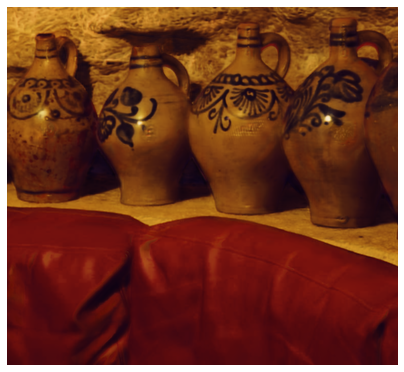

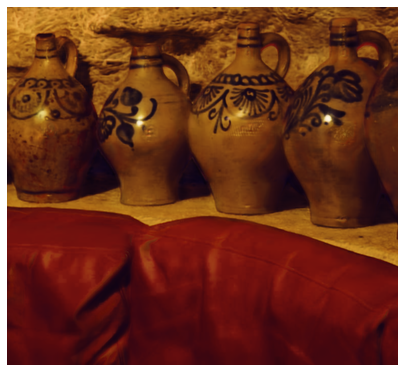

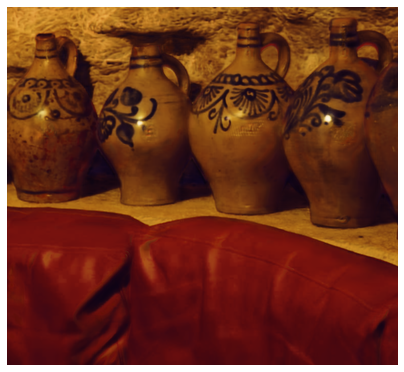

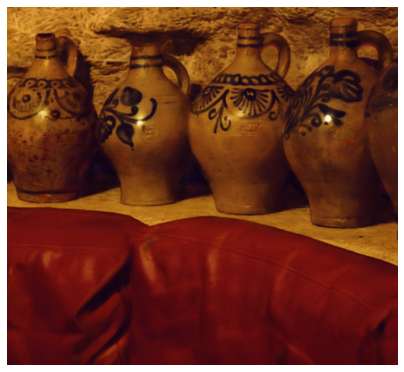

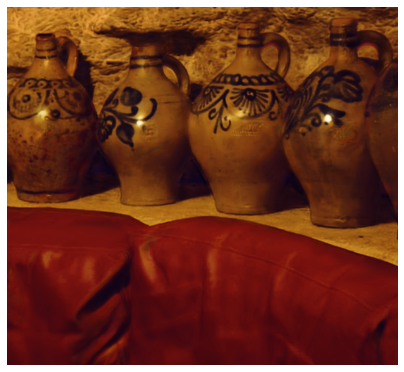

Elapsed time is 141.22529435157776 seconds.


In [7]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    duration = time.time() - startTime_for_tictoc
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(duration) + " seconds.")
    else:
        print("Toc: start time not set")
    return duration

from pdb import set_trace
i = 0
loss_list=list()
def closure():
    
    global i, net_input, loss_list
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
   
    total_loss = mse(out, img_noflash_var)
    if i%20==0:loss_list.append(total_loss.data.cpu())
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    #     filename = "flash_iter"+str(i)
    #     #if dcvx_:filename = filename+"_dcvx_"+str()
    #     filename = filename+".pdf"

    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        #set_trace()
        #savefig(filename)
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
tic()
optimize(OPTIMIZER, p, closure, LR, num_iter)
dur = toc()
loss_list = np.asarray(loss_list)


Sometimes the process stucks at reddish image, just run the code from the top one more time. 

In [8]:
print(loss_list)

[0.1340961  0.01548285 0.01211238 0.01005663 0.00918795 0.00910525
 0.00853373 0.00802489 0.00786717 0.00775575 0.00760975 0.00747442
 0.00758593 0.00759378 0.00728876 0.00746258 0.00713101 0.00719243
 0.00720245 0.0070123  0.00717118 0.00700233 0.00732294 0.00691183
 0.00694715 0.00689156 0.00696544 0.00675416 0.00697585 0.00671998
 0.00688681 0.00673222 0.00669512 0.00668074 0.00680463 0.00666515
 0.00672861 0.00671239 0.00670822 0.00656649 0.00672815 0.00657432
 0.00661412 0.00655959 0.00654992 0.00658125 0.00652036 0.00652542
 0.00649254 0.00651485 0.00646331]


In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_noflash_np], factor=13);

In [ ]:
del net
torch.cuda.empty_cache()